In [2]:
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import mud.funs as mdf
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sys.path.insert(0, os.path.dirname(os.getcwd()))

from dc_models.models import *
from dc_utils.plots import _create_paramdf, _plot_states, _print_dims

# # Statistics libraries
# from scipy.stats import uniform, norm
# from scipy.stats import gaussian_kde as GKDE

In [3]:
from distutils.spawn import find_executable

if find_executable("latex"):
    print("latex installed")

latex installed


## Mud estimation example for predator prey model

- Model: 
$$
\begin{aligned}
& \frac{d x}{d t}=\alpha x-\beta x y \\
& \frac{d y}{d t}=\delta x y-\gamma y
\end{aligned}
$$
where
- $x$ is the number of prey (for example, rabbits);
- $y$ is the number of some predator (for example, foxes);
- $\frac{d y}{d t}$ and $\frac{d x}{d t}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha, \beta, \gamma, \delta$ are positive real parameters describing the interaction of the two species.

**Implementation Note/Issue:**

The given ode system has a two-dimensional state vector consisting of $x$ and $y$ and 4 separate parameters ($\lambda$'s) i.e. $\alpha, \beta, \gamma, \delta$ to estimate the mud points of.

### Parameter reduction

Note that the parameters $(\alpha, \beta, \gamma, \delta)$ are related as follows.
By the change of variables $x \rightarrow \hat{x}(\gamma/\delta)$, $y \rightarrow \hat{y}(\alpha/\beta)$, and $t \rightarrow \hat{t}/a$ we have:

$$
\begin{aligned}
& \frac{d \hat{x}}{d t}= \hat{x} - \hat{x}\hat{y} \\
& \frac{d \hat{y}}{d t}= \eta(-\hat{y} + \hat{x}\hat{y})
\end{aligned}
$$

Where 

$$
\eta = \gamma/\delta
$$

### Generate the samples from the forward model

In [4]:
def generate_forward_runs(model, args, nruns, state_samples):
    """ """
    for i in range(nruns):

        if model.__eq__("lv"):
            m = lotka_volterra(**args)
        else:
            m = None

        m._run_model()
        states, params, times = m._get_outputs()
        states_dim = states.shape

        if i == 0:
            runs = states[:, :: (states_dim[1] // state_samples), :]
            pdims = params.shape
            lambdas = np.zeros([nruns, pdims[0], pdims[1]])
            lambdas[0, :, :] = params

        else:
            runs = np.append(
                runs, states[:, :: (states_dim[1] // state_samples), :], axis=0
            )
            lambdas[i, :, :] = params

    return runs, lambdas

### Generate true parameter values to be estimated for $\alpha, \beta, \gamma, \delta$

- Note we initially set drift_windows and assim_windows = 1 to attempt a non-sequential data-consistent inversion problem before attempting sequential estimation
- Initially set the true values of all four paramters to 0.5 for simplicity
- Let *state_samples* be the output of our observation operator (or number of observations), which in this case will be 50
- Let *num_samples* be the number of forward runs of our model, which will be 100 for this example

In [153]:
# mud parameters
num_timesteps = 1000  # number of samples to take from true state trajectory
num_samples = 1000  # number of samples to draw per parameter


true_args = {
    "state_init": np.array([4, 2]),
    "true_model": True,
    "num_tsteps": 10000,
    "tend": 200,
    "num_parameters": 4,
    "lambda_true": [0.5] * 4,
    "supports": [[0, 1]] * 4,
    "drift_windows": 1,
    "assim_windows": 1,
}

true_states, true_lambdas = generate_forward_runs("lv", true_args, 1, num_timesteps)

true_states.shape, true_lambdas.shape
true_states[0].shape

(1000, 2)

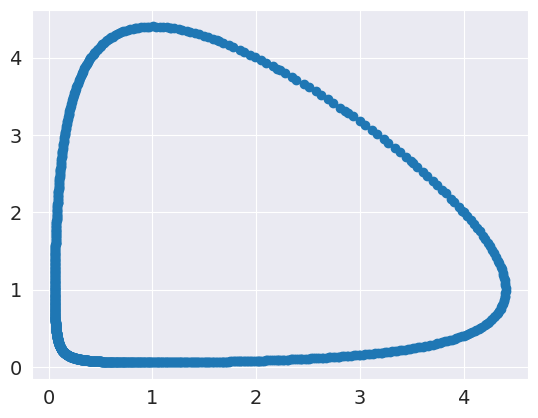

In [154]:
plt.scatter(true_states[0][:, 0], true_states[0][:, 1])

#### Generate parameter predictions for $\alpha, \beta, \gamma, \delta$

- Note we use the same support [0,1] for the uniform distributions for each parameter for simplicity

In [155]:
domain = [0, 1]
# domain = [0.4, 0.6]
predict_args = {
    "state_init": np.array([4, 2]),
    "true_model": False,
    "num_tsteps": 1000,
    "tend": 200,
    "num_parameters": 4,
    "supports": [domain] * 4,
    "drift_windows": 1,
    "assim_windows": 1,
}
predict_states, predict_lambdas = generate_forward_runs(
    "lv", predict_args, num_samples, num_timesteps
)

predict_states.shape, predict_lambdas.shape

((1000, 1000, 2), (1000, 1, 4))

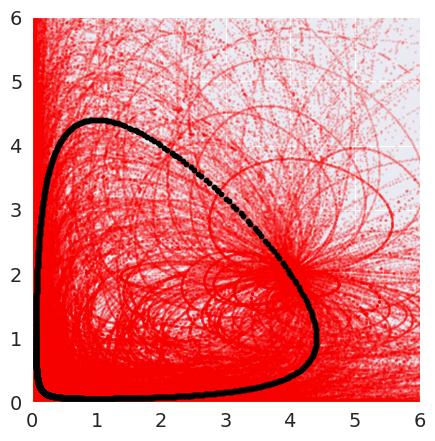

In [156]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
for n in range(num_samples):
    ax.scatter(
        predict_states[n][:, 0], predict_states[n][:, 1], s=1, alpha=0.1, color="red"
    )
ax.set_ylim([0, 6])
ax.set_xlim([0, 6])
plt.scatter(true_states[0][:, 0], true_states[0][:, 1], color='black', s=10)

### This section can be ignored for now

In [157]:
# truelv_df = _create_paramdf(true_lambdas[0],cols='pp',names=None)
# predictlv_df = _create_paramdf(predict_lambdas[0],cols='pp',names=None)

# print(f"True sampled state (qoi_true) dimensions: {true_states.shape}\n")
# print(f"True lambda value dimensions: {true_lambdas.shape} \n")
# display(truelv_df)
# print(f"Predicted sampled state (qoi) dimensions: {predict_states.shape} \n")
# print(f"Predicted lambda value dimensions: {predict_lambdas.shape} \n")
# display(predictlv_df)

## Mud Estimation

In [158]:
from mud.base import SpatioTemporalProblem as STP

data = {
    "sample_dist": "u",
    "domain": np.array(domain * 4),
    "sensors": np.array([[0, 0], [0, 0]]),
    "times": np.arange(0, num_timesteps),
    "lam_ref": true_lambdas.reshape(4, 1),
    "std_dev": 0.1,
    "true_vals": true_states[0],
    "lam": predict_lambdas.reshape(num_samples, 4),
    "data": predict_states,
}

spatio_temporal_data = STP(df=data)

# Generate artifical measurements from true values
sd = 1.5e-3
spatio_temporal_data.measurements_from_reference(std_dev=np.sqrt(sd), seed=21)

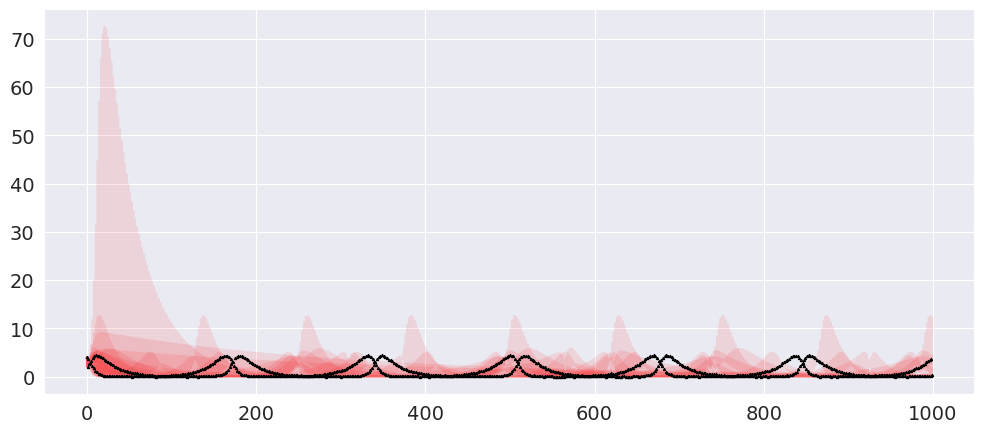

In [159]:
_ = spatio_temporal_data.plot_ts(max_plot=10)

In [162]:
# mud_prob_1 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=1)
# mud_prob_2 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=2)
# mud_prob_3 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=2)
# [[mud_prob_1.estimate(), mud_prob_1.expected_ratio()],
#  [mud_prob_2.estimate(), mud_prob_2.expected_ratio()],
#  [mud_prob_3.estimate(), mud_prob_3.expected_ratio()]]

In [163]:
np.linalg.norm(true_lambdas.reshape(4,1)-mud_prob_1.estimate()), mud_prob_1.expected_ratio()

(1.262818248663591, 1.5380642508021797e+49)

In [164]:
np.linalg.norm(true_lambdas.reshape(4,1)-mud_prob_2.estimate()), mud_prob_2.expected_ratio()

(1.2461653537049784, nan)

## Iterative procedure outline

Illustrating here using only 1 principle component each iteration, and fixed timestep sizes of 50 timesteps. 
But in theory we could use variable time steps and number of components, and should. 
Want to check `expected_ratio()` at each iteration.

### Iteration 1

In [165]:
mud_prob_1 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,50), num_components=1)
mud_prob_1.estimate(), mud_prob_1.expected_ratio()

(array([0.76170804, 0.55914293, 0.32016114, 0.93985798]),
 8.676568758781199e+22)

### Iteration 2

We now want to use the r ratio to re-weight samples on the next iteration if we aren't re-sampling

In [149]:
mud_prob_1._r.shape, mud_prob_1._r[0:10]

((1000,),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.02506405e-74, 0.00000000e+00]))

In [150]:
mud_prob_2 = spatio_temporal_data.mud_problem(times_mask=np.arange(51,100),
                                              num_components=1,
                                              sample_weights=mud_prob_1._r)

In [151]:
mud_prob_2.estimate(), mud_prob_2.expected_ratio()

(array([0.06711241, 0.80354358, 0.64072544, 0.79815769]), nan)

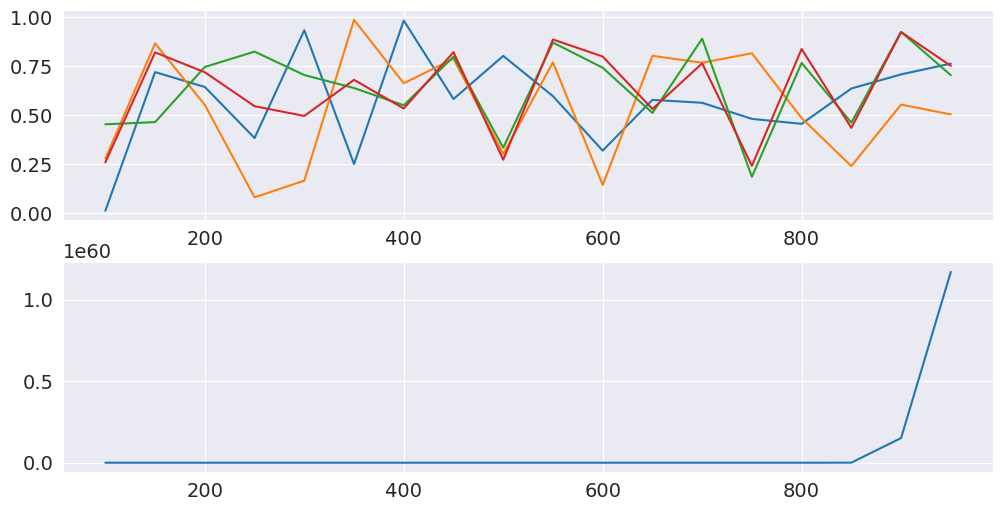

In [167]:
ts_1  = np.arange(start=100, stop=1000, step=50, dtype=int)
estimates = []
e_rs = []
for i in ts_1:
    mud_prob_1 = spatio_temporal_data.mud_problem(times_mask=np.arange(1,i),
                                                  num_components=1)
    estimates.append(mud_prob_1.estimate())
    e_rs.append(mud_prob_1.expected_ratio())
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts_1, estimates)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(ts_1, e_rs)

In [99]:
mud_prob_2 = spatio_temporal_data.mud_problem(times_mask=np.arange(501,1000),
                                              num_components=2,
                                              sample_weights=mud_prob_1._r)

In [100]:
mud_prob_2.estimate(), mud_prob_2.expected_ratio()

(array([0.51323356, 0.5418203 , 0.55790236, 0.46971529]), 0.0)

## Re-sampling iterations

TODO: re-sample from updated distributions between an iteration

In [7]:
qoi_true2d = true_states[0, :, :]
qoi2d = predict_states
lam = predict_lambdas[:, 0, 0]
print(qoi_true2d.shape)
print(qoi2d.shape)
print(lam.shape)

(50, 2)
(100, 50, 2)
(100,)


##### Result: Cannot construct the map of a 2D state vector

In [8]:
mud_problem2d = mdf.mud_problem(
    domain=[[0, 1]],
    lam=lam,
    qoi=qoi2d,
    sd=np.sqrt(1.5e-3),
    qoi_true=qoi_true2d,
    num_obs=state_samples,
)

ValueError: operands could not be broadcast together with shapes (50,2) (50,) 

#### Case: 1D state vector (we choose $x$ arbitrarily) and 4 dimensional $\lambda$ parameter vector
####  i.e. $x \in \mathbb{R}^{Nobs \times 1}, \quad \lambda \in \mathbb{R}^{4} $

In [11]:
qoi_true = true_states[0, :, 0]
qoi = predict_states[:, :, 0]
lam4d = predict_lambdas
print(qoi_true.shape)
print(qoi.shape)
print(lam4d.shape)

(50,)
(100, 50)
(100, 1, 4)


In [13]:
mud_problem4dparam = mdf.mud_problem(
    domain=[[0, 1]],
    lam=lam4d,
    qoi=qoi,
    sd=np.sqrt(1.5e-3),
    qoi_true=qoi_true,
    num_obs=state_samples,
)

##### Result: Cannot construct estimate the 4d parameter vector

In [14]:
mud_problem4dparam.estimate()

ValueError: operands could not be broadcast together with shapes (100,4) (100,) 